In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! mkdir ~/.kaggle
! cp drive/MyDrive//kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

train_dir = os.path.abspath(os.getcwd()) + "/chest_xray/train/"
test_dir = os.path.abspath(os.getcwd()) + "/chest_xray/test/"

print(train_dir)
print(tf.__version__)

/content/chest_xray/train/
2.7.0


In [4]:
%load_ext tensorboard

In [5]:
batch_size = 32 # number of training examples used in one iteration

train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, subset="training", seed=543, validation_split=0.2, labels='inferred')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, subset="validation", seed=543, validation_split=0.2, labels='inferred')
print('-----')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir)
print(train_ds.class_names)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
-----
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']


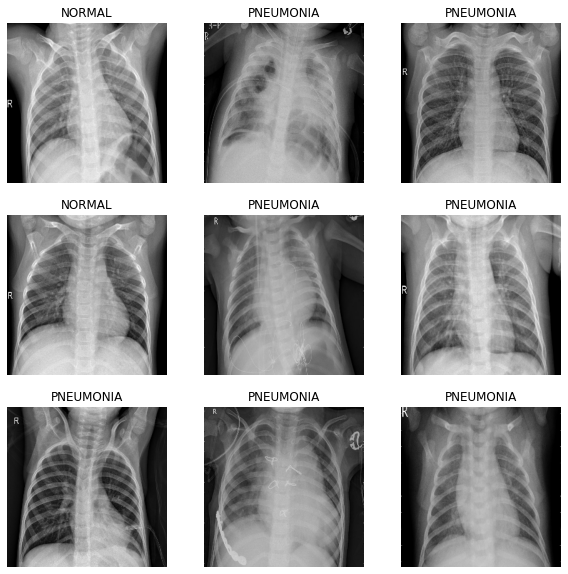

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Introduction

You will find 4 simple CNN models, each with a different number of layers, and all that are trained with 5 epochs, a Rectified Linear Unit (ReLU) activition, and a final flatten layer before output.

The first model is a ***naive solution***, it is meant to showcase how selecting your layers can significantly improve performance with little to no loss in model accuracy.

Models 2 and 3 are attempts to optimize the first model, with each model getting smaller.

Model 4 is the final CNN, it is meant to show that ***optimizing a model is not only gradually removing layers***. In this model we add two more layers, and set the output filters to 2.

***A small random subset of the testing data will be printed*** to get an idea of the results and the confidence level of the models during predictions. 

***Below each model will be the accuracy metric of the model***. All other metrics (such as precision and recall) are unnecessary for the time being since we are only focusing on optimization of time and accuracy for the model.

### Pre-requisite information 

***Tensor:*** Tensors are multi-dimensional arrays.

In short:

***rank-0 tensor:*** A scalar. <br>
***rank-1 tensor:*** A vector. <br>
***rank-2 tensor:*** A matrix. <br>
<br>
We use ***rank-4 tensors*** of `float32` type, the dimensions refer to: `(batch_size, height, width, RGB channels)`.



---
***Convolution filter:*** A matrix having the same rank as the input matrix, but a smaller shape. The initial filter is randomly generated, and adjusted during training. <br>


---


***Convolution:*** Denoted by 𝑓 * 𝑔 (read convolution of 𝑓 and 𝑔) , process of applying a filter to an input matrix from the image. For [reference see the official documents from google](https://developers.google.com/machine-learning/glossary/#convolution).


---


***Pooling Layer:*** Reducing the size of a matrix created by a convolutional layer. Pooling usually involves taking either the maximum or average value across the pooled area. 

# Analysis

## A look at the image dimensions

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
print(image_batch[0])

(32, 256, 256, 3)
(32,)
tf.Tensor(
[[[150.21484  150.21484  150.21484 ]
  [147.50781  147.50781  147.50781 ]
  [151.46094  151.46094  151.46094 ]
  ...
  [ 28.902344  28.902344  28.902344]
  [ 27.46875   27.46875   27.46875 ]
  [ 25.136719  25.136719  25.136719]]

 [[148.22266  148.22266  148.22266 ]
  [139.08984  139.08984  139.08984 ]
  [136.91016  136.91016  136.91016 ]
  ...
  [ 30.625     30.625     30.625   ]
  [ 29.292969  29.292969  29.292969]
  [ 26.78125   26.78125   26.78125 ]]

 [[140.34766  140.34766  140.34766 ]
  [129.83203  129.83203  129.83203 ]
  [110.40625  110.40625  110.40625 ]
  ...
  [ 32.375     32.375     32.375   ]
  [ 31.175781  31.175781  31.175781]
  [ 29.        29.        29.      ]]

 ...

 [[ 11.        11.        11.      ]
  [ 11.        11.        11.      ]
  [ 11.        11.        11.      ]
  ...
  [ 11.21875   11.21875   11.21875 ]
  [ 12.        12.        12.      ]
  [ 12.        12.        12.      ]]

 [[ 11.        11.        11.      ]
  

According to the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory#returns), 3 channels (last dimension of image_batch tensor) corresponds to color channels RGB. Needs standardization to go from RGB to grayscale. We can introduce rescaling through `layers.experimental.preprocessing.Rescaling`.

## Model 1

In [8]:
num_classes = 2
model_1 = Sequential(
    [
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)), # rescaling layer
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu') ,
    layers.MaxPooling2D(),
    layers.Dense(128) ,
    layers.Flatten(),
    layers.Dense(num_classes) ,
    ]
)

In [9]:
model_1.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model_1.build(input_shape=image_batch.shape)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dense (Dense)               (None, 64, 64, 128)       8

In [11]:
% rm -rf ./logs/
checkpoint_path = "/content/drive/MyDrive/model_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

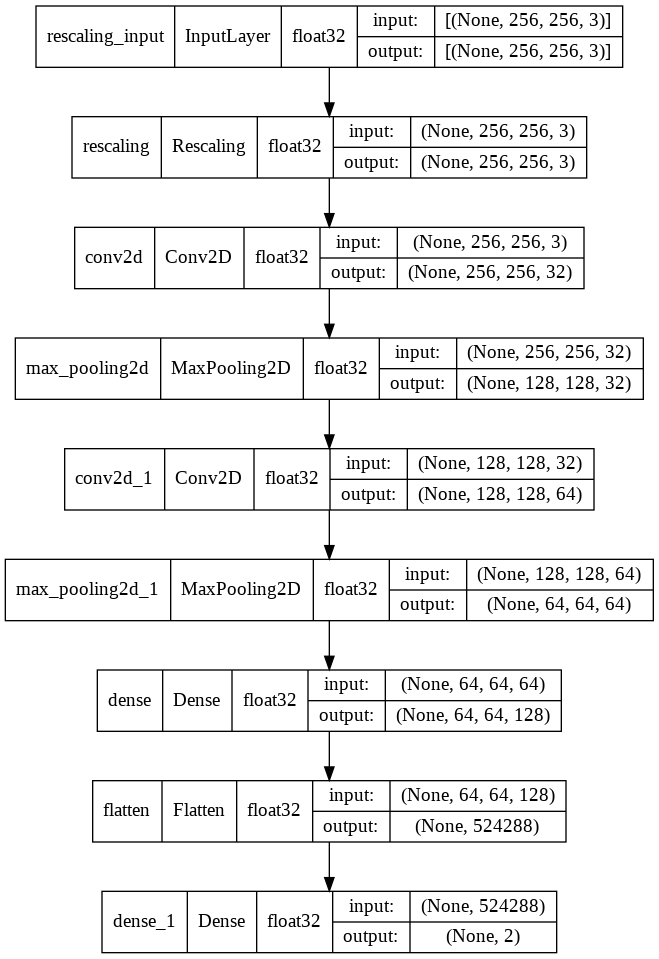

In [12]:
tf.keras.utils.plot_model(
    model_1,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

### Training Model 1

In [13]:
# DO NOT RUN IF THERE IS A CHECKPOINT OR OUTPUT, LOAD CHECKPOINT IN THE NEXT LINE INSTEAD
epochs=5
history = model_1.fit(
  train_ds, 
  validation_data=val_ds,
  epochs=epochs , 
  callbacks=[cp_callback , tensorboard_callback]
)

Epoch 1/5
131/131 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.8462
Epoch 00001: saving model to /content/drive/MyDrive/model_1/cp.ckpt
131/131 [==============================] - 436s 3s/step - loss: 0.8200 - accuracy: 0.8462 - val_loss: 0.1149 - val_accuracy: 0.9511
Epoch 2/5
131/131 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9641
Epoch 00002: saving model to /content/drive/MyDrive/model_1/cp.ckpt
131/131 [==============================] - 442s 3s/step - loss: 0.0997 - accuracy: 0.9641 - val_loss: 0.1065 - val_accuracy: 0.9616
Epoch 3/5
131/131 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9758
Epoch 00003: saving model to /content/drive/MyDrive/model_1/cp.ckpt
131/131 [==============================] - 434s 3s/step - loss: 0.0666 - accuracy: 0.9758 - val_loss: 0.0851 - val_accuracy: 0.9674
Epoch 4/5
131/131 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9784
Epoch 00004: saving 

In [14]:
model_1.load_weights(checkpoint_path)
loss, acc = model_1.evaluate(val_ds)

33/33 [==============================] - 34s 977ms/step - loss: 0.0840 - accuracy: 0.9741


### Test data with Model 1 

In [15]:
for images,labels in test_ds.take(3):
  for i in range(9):
    img_array = tf.expand_dims(images[i], 0)
    predictions = model_1.predict(img_array)
    score = tf.nn.softmax(predictions)
    print("Predicted:", test_ds.class_names[np.argmax(score)], 100 * np.max(score))
    print("Actual:" , train_ds.class_names[labels[i]])
    print()

Predicted: PNEUMONIA 99.99840259552002
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99988079071045
Actual: PNEUMONIA

Predicted: PNEUMONIA 90.25478959083557
Actual: NORMAL

Predicted: PNEUMONIA 100.0
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.96339082717896
Actual: NORMAL

Predicted: PNEUMONIA 99.97768998146057
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99841451644897
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99464750289917
Actual: PNEUMONIA

Predicted: PNEUMONIA 89.88291621208191
Actual: NORMAL

Predicted: NORMAL 96.58911228179932
Actual: NORMAL

Predicted: PNEUMONIA 99.99984502792358
Actual: PNEUMONIA

Predicted: NORMAL 96.72830104827881
Actual: NORMAL

Predicted: PNEUMONIA 99.99594688415527
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.94088411331177
Actual: NORMAL

Predicted: PNEUMONIA 99.9807059764862
Actual: PNEUMONIA

Predicted: PNEUMONIA 100.0
Actual: PNEUMONIA

Predicted: PNEUMONIA 85.93682646751404
Actual: PNEUMONIA

Predicted: PNEUMONIA 100.0
Actual: PNEUMONIA

Predicted: PNEUMO

### Conclusion

Model 1 is a very poor performing model in terms of wait times for training (roughly 6-8 mins per epoch, with 5 epochs = total of 30-40 mins). In general, a large type of NN like this should never be used outside of demonstration purposes of how layers affect training times.

However, the accuracy of the model did reach slightly above 97%, which is very good. We can improve on performance without sacrificing much if any accuracy.

## Model 2

In [16]:
checkpoint_path = "/content/drive/MyDrive/model_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
model_2 = Sequential(
    [
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)), # rescaling layer
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(64) ,
    layers.Flatten(),
    layers.Dense(num_classes) ,
    ]
)

In [18]:
model_2.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

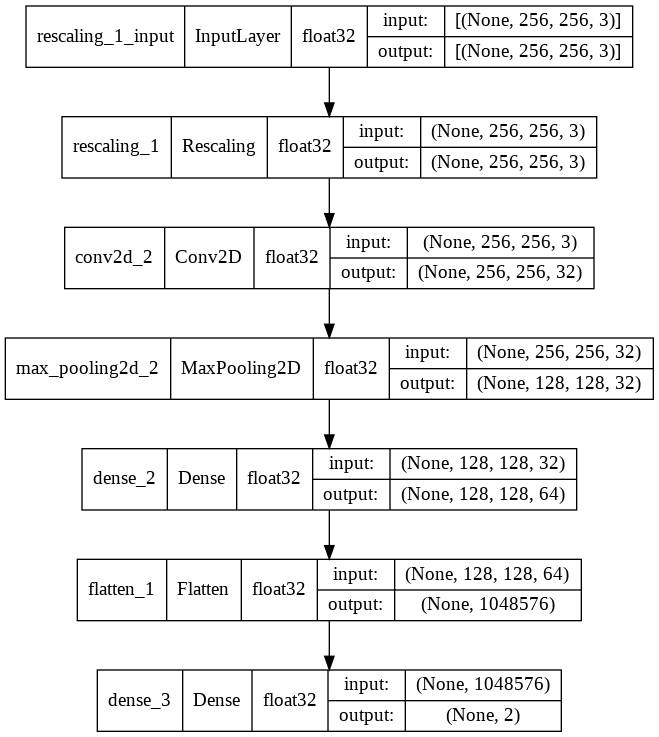

In [19]:
tf.keras.utils.plot_model(
    model_2,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

### Training Model 2

In [20]:
# DO NOT RUN IF THERE IS A CHECKPOINT or OUTPUT, LOAD CHECKPOINT IN THE NEXT LINE INSTEAD
epochs=5
history = model_2.fit(
  train_ds, 
  validation_data=val_ds,
  epochs=epochs , 
  callbacks=[cp_callback , tensorboard_callback]
)

Epoch 1/5
131/131 [==============================] - ETA: 0s - loss: 1.0758 - accuracy: 0.8989
Epoch 00001: saving model to /content/drive/MyDrive/model_2/cp.ckpt
131/131 [==============================] - 252s 2s/step - loss: 1.0758 - accuracy: 0.8989 - val_loss: 0.2128 - val_accuracy: 0.9185
Epoch 2/5
131/131 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9729
Epoch 00002: saving model to /content/drive/MyDrive/model_2/cp.ckpt
131/131 [==============================] - 231s 2s/step - loss: 0.0767 - accuracy: 0.9729 - val_loss: 0.0850 - val_accuracy: 0.9674
Epoch 3/5
131/131 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9854
Epoch 00003: saving model to /content/drive/MyDrive/model_2/cp.ckpt
131/131 [==============================] - 233s 2s/step - loss: 0.0441 - accuracy: 0.9854 - val_loss: 0.0779 - val_accuracy: 0.9703
Epoch 4/5
131/131 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9923
Epoch 00004: saving 

In [21]:
model_2.load_weights(checkpoint_path)
loss, acc = model_2.evaluate(val_ds)

33/33 [==============================] - 22s 636ms/step - loss: 0.0689 - accuracy: 0.9732


### Test data with Model 2

In [22]:
for images,labels in test_ds.take(3):
  for i in range(9):
    img_array = tf.expand_dims(images[i], 0)
    predictions = model_2.predict(img_array)
    score = tf.nn.softmax(predictions)
    print("Predicted:", test_ds.class_names[np.argmax(score)], 100 * np.max(score))
    print("Actual:" , train_ds.class_names[labels[i]])
    print()

Predicted: PNEUMONIA 99.94080066680908
Actual: PNEUMONIA

Predicted: PNEUMONIA 64.49472308158875
Actual: NORMAL

Predicted: PNEUMONIA 99.99340772628784
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99967813491821
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99988079071045
Actual: PNEUMONIA

Predicted: PNEUMONIA 98.0256974697113
Actual: NORMAL

Predicted: PNEUMONIA 66.23829007148743
Actual: NORMAL

Predicted: PNEUMONIA 99.99998807907104
Actual: PNEUMONIA

Predicted: PNEUMONIA 100.0
Actual: PNEUMONIA

Predicted: PNEUMONIA 100.0
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99926090240479
Actual: PNEUMONIA

Predicted: PNEUMONIA 100.0
Actual: PNEUMONIA

Predicted: PNEUMONIA 100.0
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99991655349731
Actual: PNEUMONIA

Predicted: PNEUMONIA 92.1014130115509
Actual: NORMAL

Predicted: PNEUMONIA 100.0
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.98548030853271
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.98984336853027
Actual: PNEUMONIA

Predicted: PNEUMONIA 97.789859

### Conclusion

We removed a pooling and convolution layer in Model 2. Which ultimately passes larger sized matrices to the final layers. 

Model 2 has significantly better performance than Model 1 while retaining almost the same level of accuracy. Each epoch in Model 2 took less than 5 mins, a substantial improvement from Model 1.



## Model 3

In [23]:
checkpoint_path = "/content/drive/MyDrive/model_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [24]:
model_3 = Sequential(
    [
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)), # rescaling layer
    layers.Conv2D(32, 3, padding='same', activation='relu') ,
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes) ,
    ]
)

In [25]:
model_3.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

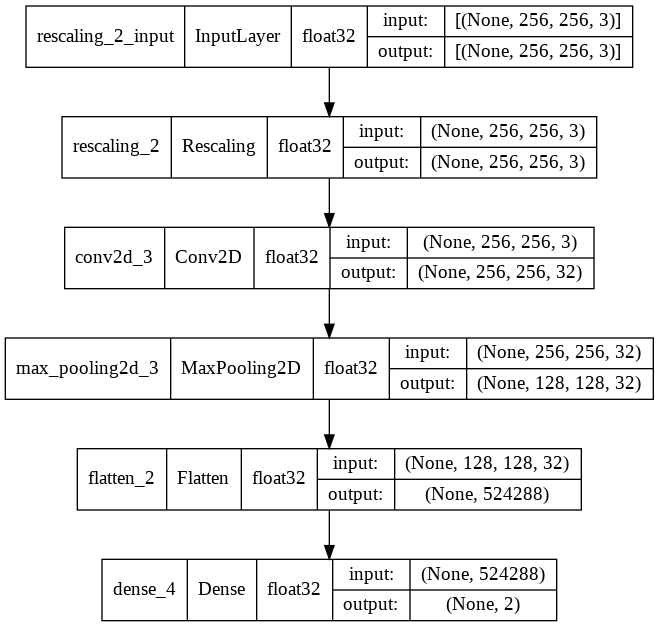

In [26]:
tf.keras.utils.plot_model(
    model_3,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

### Training Model 3

In [27]:
# DO NOT RUN IF THERE IS A CHECKPOINT, LOAD CHECKPOINT IN THE NEXT LINE INSTEAD
epochs=5
history = model_3.fit(
  train_ds, 
  validation_data=val_ds,
  epochs=epochs , 
  callbacks=[cp_callback , tensorboard_callback]
)

Epoch 1/5
131/131 [==============================] - ETA: 0s - loss: 1.3964 - accuracy: 0.8797
Epoch 00001: saving model to /content/drive/MyDrive/model_3/cp.ckpt
131/131 [==============================] - 196s 1s/step - loss: 1.3964 - accuracy: 0.8797 - val_loss: 0.1149 - val_accuracy: 0.9569
Epoch 2/5
131/131 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9739
Epoch 00002: saving model to /content/drive/MyDrive/model_3/cp.ckpt
131/131 [==============================] - 193s 1s/step - loss: 0.0759 - accuracy: 0.9739 - val_loss: 0.0797 - val_accuracy: 0.9770
Epoch 3/5
131/131 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9871
Epoch 00003: saving model to /content/drive/MyDrive/model_3/cp.ckpt
131/131 [==============================] - 192s 1s/step - loss: 0.0418 - accuracy: 0.9871 - val_loss: 0.1919 - val_accuracy: 0.9175
Epoch 4/5
131/131 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9878
Epoch 00004: saving 

In [28]:
model_3.load_weights(checkpoint_path)
loss, acc = model_3.evaluate(val_ds)

33/33 [==============================] - 19s 529ms/step - loss: 0.0717 - accuracy: 0.9732


### Test data with Model 3

In [29]:
for images,labels in test_ds.take(3):
  for i in range(9):
    img_array = tf.expand_dims(images[i], 0)
    predictions = model_3.predict(img_array)
    score = tf.nn.softmax(predictions)
    print("Predicted:", test_ds.class_names[np.argmax(score)], 100 * np.max(score))
    print("Actual:" , train_ds.class_names[labels[i]])
    print()

Predicted: NORMAL 89.85208868980408
Actual: NORMAL

Predicted: PNEUMONIA 99.88732933998108
Actual: PNEUMONIA

Predicted: PNEUMONIA 98.80375862121582
Actual: PNEUMONIA

Predicted: PNEUMONIA 100.0
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99991655349731
Actual: PNEUMONIA

Predicted: PNEUMONIA 94.82324719429016
Actual: NORMAL

Predicted: PNEUMONIA 99.99964237213135
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.9969482421875
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99818801879883
Actual: NORMAL

Predicted: PNEUMONIA 99.63087439537048
Actual: PNEUMONIA

Predicted: PNEUMONIA 88.80005478858948
Actual: NORMAL

Predicted: NORMAL 96.4251697063446
Actual: NORMAL

Predicted: PNEUMONIA 99.85659718513489
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.78148937225342
Actual: NORMAL

Predicted: NORMAL 95.2355682849884
Actual: NORMAL

Predicted: PNEUMONIA 99.99973773956299
Actual: PNEUMONIA

Predicted: NORMAL 99.17595982551575
Actual: NORMAL

Predicted: PNEUMONIA 82.70682096481323
Actual: PNEUMONIA

Predict

### Conclusion

Model 3 contains only one convolution and pooling layer. Despite being such a small model, it has impressive training times of just past 3 mins per epoch. 

Furthermore, model 3 still maintains excellent accuracy, which is largely thanks to the large kernel size of the convolution layer. 

## Model 4

In [56]:
checkpoint_path = "/content/drive/MyDrive/model_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [57]:
model_4 = Sequential(
    [
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)), # rescaling layer
    layers.Conv2D(2, 3, padding='same', activation='relu') ,
    layers.MaxPooling2D(),
    layers.Conv2D(2, 3, padding='same', activation='relu') ,
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes) ,
    ]
)

In [58]:
model_4.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

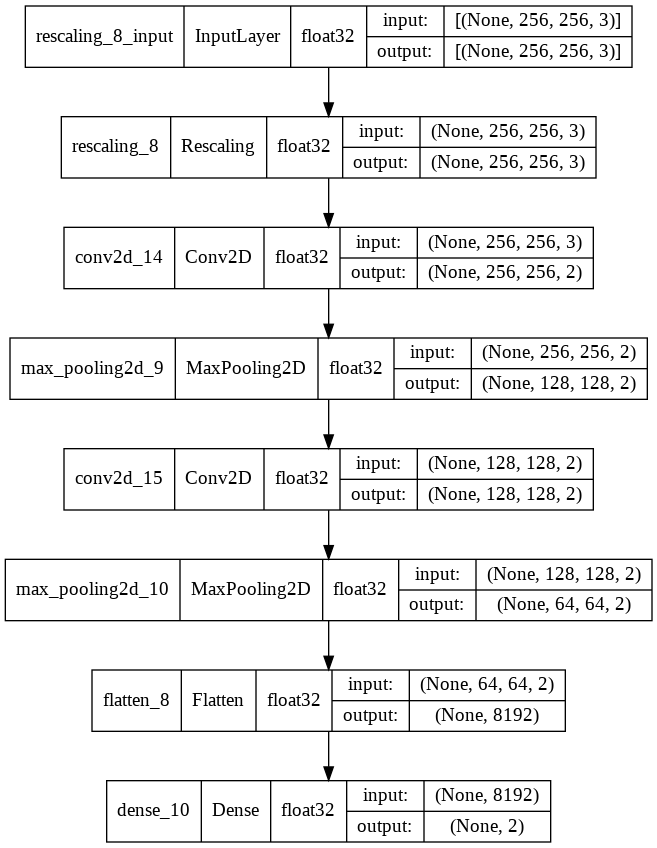

In [59]:
tf.keras.utils.plot_model(
    model_4,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

### Training Model 4

In [60]:
# DO NOT RUN IF THERE IS A CHECKPOINT, LOAD CHECKPOINT IN THE NEXT LINE INSTEAD
epochs=5
history = model_4.fit(
  train_ds, 
  validation_data=val_ds,
  epochs=epochs , 
  callbacks=[cp_callback , tensorboard_callback]
)

Epoch 1/5
131/131 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.8917
Epoch 00001: saving model to /content/drive/MyDrive/model_4/cp.ckpt
131/131 [==============================] - 140s 1s/step - loss: 0.2704 - accuracy: 0.8917 - val_loss: 0.1313 - val_accuracy: 0.9521
Epoch 2/5
131/131 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9597
Epoch 00002: saving model to /content/drive/MyDrive/model_4/cp.ckpt
131/131 [==============================] - 139s 1s/step - loss: 0.1106 - accuracy: 0.9597 - val_loss: 0.0966 - val_accuracy: 0.9626
Epoch 3/5
131/131 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9681
Epoch 00003: saving model to /content/drive/MyDrive/model_4/cp.ckpt
131/131 [==============================] - 139s 1s/step - loss: 0.0919 - accuracy: 0.9681 - val_loss: 0.0910 - val_accuracy: 0.9626
Epoch 4/5
131/131 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9741
Epoch 00004: saving 

In [61]:
model_4.load_weights(checkpoint_path)
loss, acc = model_4.evaluate(val_ds)

33/33 [==============================] - 18s 487ms/step - loss: 0.0871 - accuracy: 0.9655


### Test data Model 4

In [62]:
for images,labels in test_ds.take(3):
  for i in range(9):
    img_array = tf.expand_dims(images[i], 0)
    predictions = model_4.predict(img_array)
    score = tf.nn.softmax(predictions)
    print("Predicted:", test_ds.class_names[np.argmax(score)], 100 * np.max(score))
    print("Actual:" , train_ds.class_names[labels[i]])
    print()

Predicted: PNEUMONIA 99.99961853027344
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.8354434967041
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99969005584717
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99997615814209
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.81675148010254
Actual: PNEUMONIA

Predicted: PNEUMONIA 89.0318751335144
Actual: NORMAL

Predicted: PNEUMONIA 99.8350739479065
Actual: PNEUMONIA

Predicted: PNEUMONIA 98.32484722137451
Actual: NORMAL

Predicted: NORMAL 63.73884081840515
Actual: NORMAL

Predicted: PNEUMONIA 99.99997615814209
Actual: PNEUMONIA

Predicted: PNEUMONIA 57.105785608291626
Actual: NORMAL

Predicted: PNEUMONIA 98.59587550163269
Actual: PNEUMONIA

Predicted: PNEUMONIA 90.2140736579895
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.9409556388855
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99974966049194
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.94940757751465
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.20565485954285
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.998557567

### Conclusion

Model 4 is meant to show that ***we do not need to drastically reduce the size*** of the network to improve performance. We added two layers but changed the kernel size of both convolution layers to 2. A dramatic reduction from previous layers (32). 

Although model 4 is larger than model 3, it is faster in training, but less accurate. Model 3 took roughly 3 minutes and 10 seconds per epoch, about 16 mins in total for training, whereas model 4 took about 2 minutes and 34 seconds per epoch, or a total of about 12 minutes. 

# Conclusions



Model 1 is a poot example of a high accuracy network. As the batch size and epochs get larger, it won't be a reasonable option to train when other models offer similar accuracy at substantially less cost in time and space.

Model 2 is a great improvement from model 1, however. The training time is reduced dramatically, while the accuracy is retained for the most part. 

Model 2 is still a bloated model, mostly due to the large output of the convolutional layers. This issue is better addressed in model 4. 

Model 3 is the smallest possible network we can get with a reasonable training time as well as an accuracy above 97%. Furthermore, model 3 has the fastest training time out of models 1 and 2. Model 3 is able to retain accuracy with it's large output of the convolutional layer, yet remain relatively lean. 

Model 4 is very similar to model 2 in terms of size of the network. However, the output size of the convolutional layers is far less than the size of outputs in model 2. As a comparison; model 2 outputs over 1 million values from it's flatten layer, to the final layer. Model 4 outputs just under 8200 values between the same layers. As addressed earlier, this is due to the adjustment made in the output of the convolution layers for model 4, specifically the kernel size, which are far smaller than in model 2.  Also due to these changes, model 4 is the fastest model to train, at a slight cost in accuracy. 

A smaller network does not mean a more efficient (in terms of performance and accuracy) network as demonstrated in models 2 and 4. While model 4 shows the importance of adjusting the parameters of network layers, it's not an optimal model to improve. In fact, I would recommend that model 3 is the best model out of all the ones presented, but not an optimal model, since there currently is no known way to decide an optimal model (this area is also heavily researched). However, model 3 is also the best canidate to improve on, by further reducing extra output by adjusting parameters such as kernel size, stride, etc.